- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- Remove the eclipsing binary signal (using periodic window) and model the rest of the signal
- From the simulations

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilSPLeaf()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./simulations/sim_023_lc.dat",sep=' ', header = None, names=['Time', 'LC', 'N'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
LC      float64
N       float64
dtype: object

In [4]:
X, Y, N = df['Time'].tolist(), df['LC'].tolist(), df['N'].tolist()
X, Y, N = np.array(X), np.array(Y), np.array(N)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

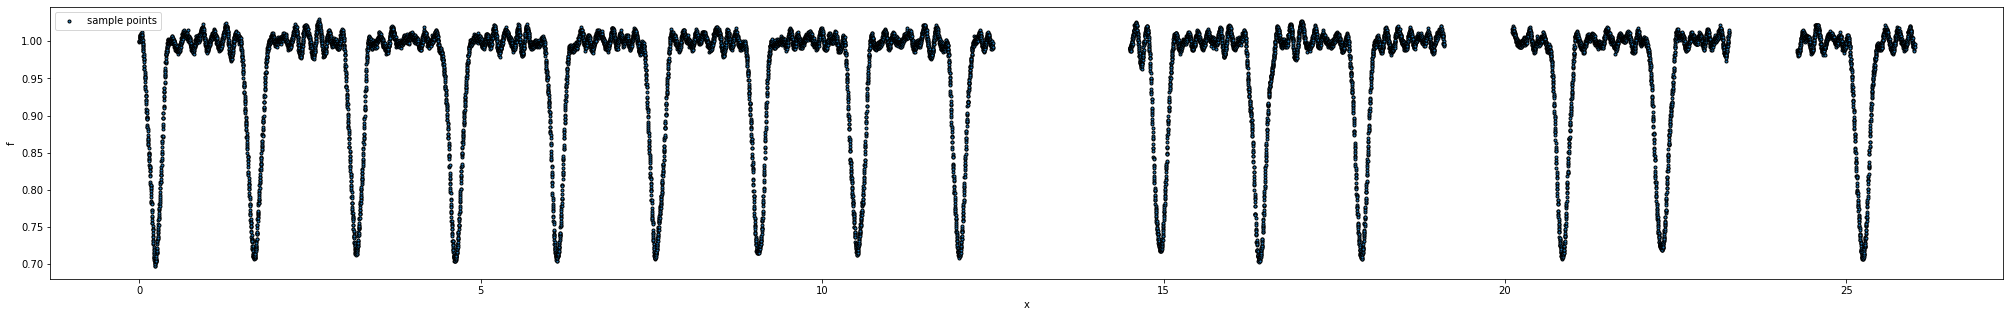

In [5]:
plotter.plot_data(X, Y)

array([0.        , 0.67695924, 0.68465196, 0.66926652, 1.3616112 ])

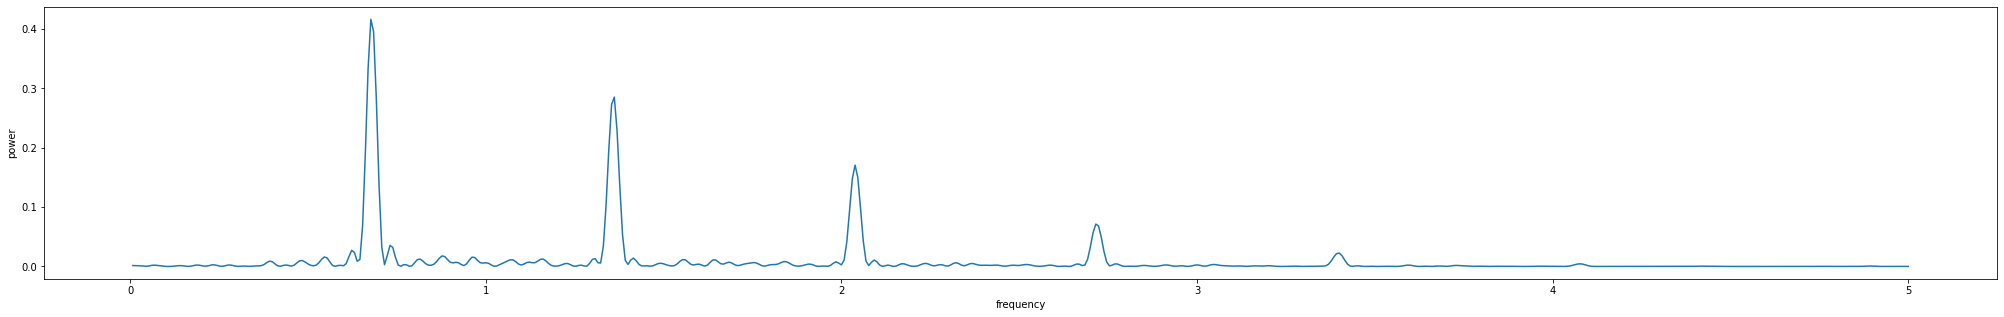

In [6]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [7]:
# 8000 is the complete first envelope for simulation 23
N_part=8000

In [8]:
X_part=X[:N_part]
Y_part=Y[:N_part]

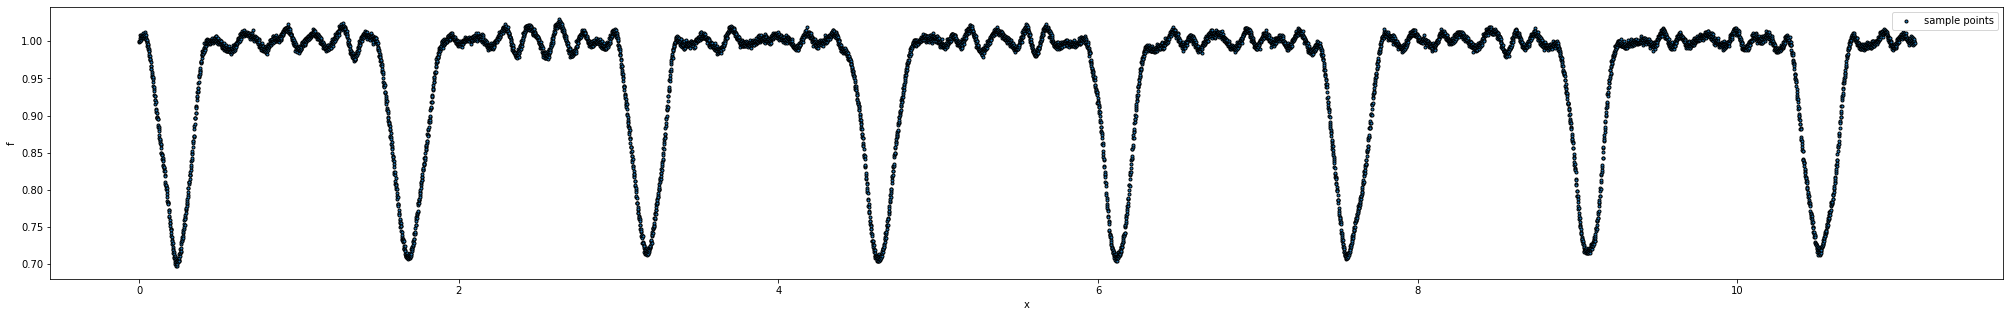

In [9]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
#    print(array.shape, value.item(), idx, array[idx].item(), array[idx-1].item())
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def clip_periodic_windows(X, Y, eclipse_duration,
                          eclipse_period, start_prim_eclipse_date, start_sec_eclipse_date):
    """
    Assumptions:
    - the secondary eclipse starts at start_prim_eclipse_date + period_sec_eclipse
    """
    max_date = X.max()
    sample_period = X[1] - X[0]
    
    # Find the next eclipse. Loop over dates here, as the positions in the array will change 
    # when we start deleting windows
    # For the second eclipse, subtract one whole period to make the loop easier to program.
    next_prim_eclipse_date, next_sec_eclipse_date = start_prim_eclipse_date, start_sec_eclipse_date - eclipse_period

    X_clipped = X.copy()
    Y_clipped = Y.copy()

    # Assume the first eclipse is a primary eclipse
    primary_eclipse = True
    next_eclipse_date = next_prim_eclipse_date

    # Now iterate over the data, first the primary eclipse, then a secondary eclipse
    while next_eclipse_date < max_date:
        # There are gaps in the X-data, so we can not delete a window of x pixels, we have to work based on dates.
        next_eclipse_x_start = find_nearest_idx(X_clipped, next_eclipse_date).item()
        next_eclipse_x_end = next_eclipse_x_start + find_nearest_idx(X_clipped[next_eclipse_x_start:], next_eclipse_date+eclipse_duration).item()

        # Now delete the window
        i = { "left" : max(int(next_eclipse_x_start), 0), "right": max(int(next_eclipse_x_end), 0)}
#        print(primary_eclipse, next_eclipse_date.item(), X_clipped[next_eclipse_x_start-2:next_eclipse_x_start+2].tolist(), i)
        X_clipped = np.concatenate((X_clipped[:i['left']], X_clipped[i['right']:]))
        Y_clipped = np.concatenate((Y_clipped[:i['left']], Y_clipped[i['right']:]))

        # Move to the next period
        primary_eclipse = not primary_eclipse
        if primary_eclipse:
            next_prim_eclipse_date += eclipse_period
            next_eclipse_date = next_prim_eclipse_date
        else:
            next_sec_eclipse_date += eclipse_period
            next_eclipse_date = next_sec_eclipse_date
           
    return X_clipped, Y_clipped

In [11]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+6) * sample_period
first_sec_eclipse_date = X_part[0] + (+1000) * sample_period
# Take the frequency with the highest amplitude from the periodogram!!
eclipse_period = 1/0.67695924

eclipse_duration = 300 * sample_period
X_part_window, Y_part_window = clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

In [12]:
# We have all timestamps with observations in X_part
# X_part_window is X_part minus the masked out eclipses
# If we want to plot the mask, subtract X_part_window from X_part and assume
# observations of amplitude 1 at those timestamps
a=X_part
b=X_part_window
X_mask=a
Y_mask=np.zeros(shape=Y_part.shape)
X_mask_idcs=np.searchsorted(a, np.setdiff1d(a, b))
Y_mask[X_mask_idcs]=1

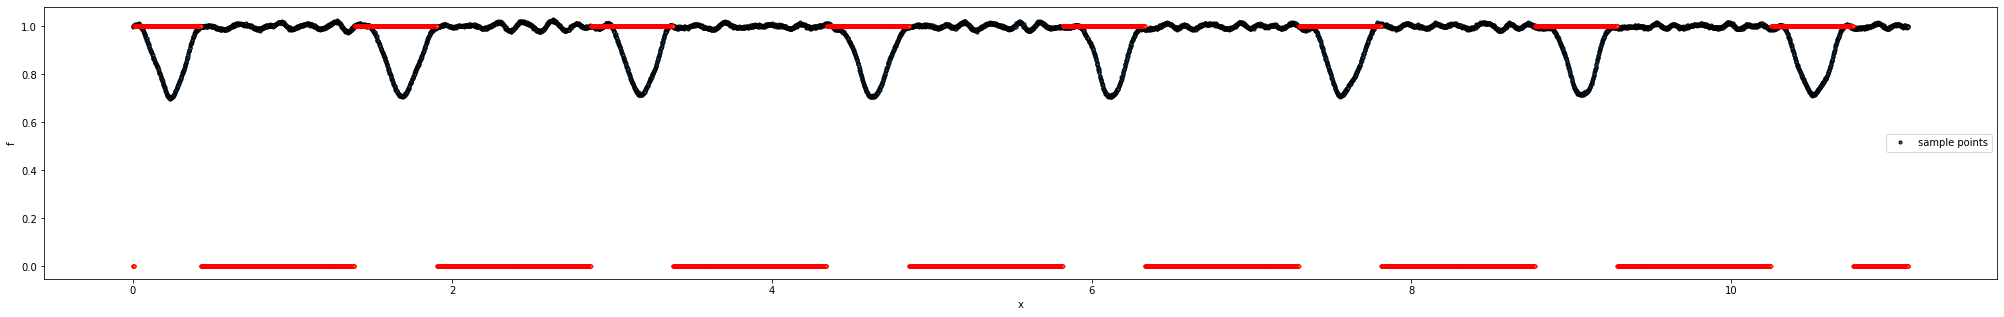

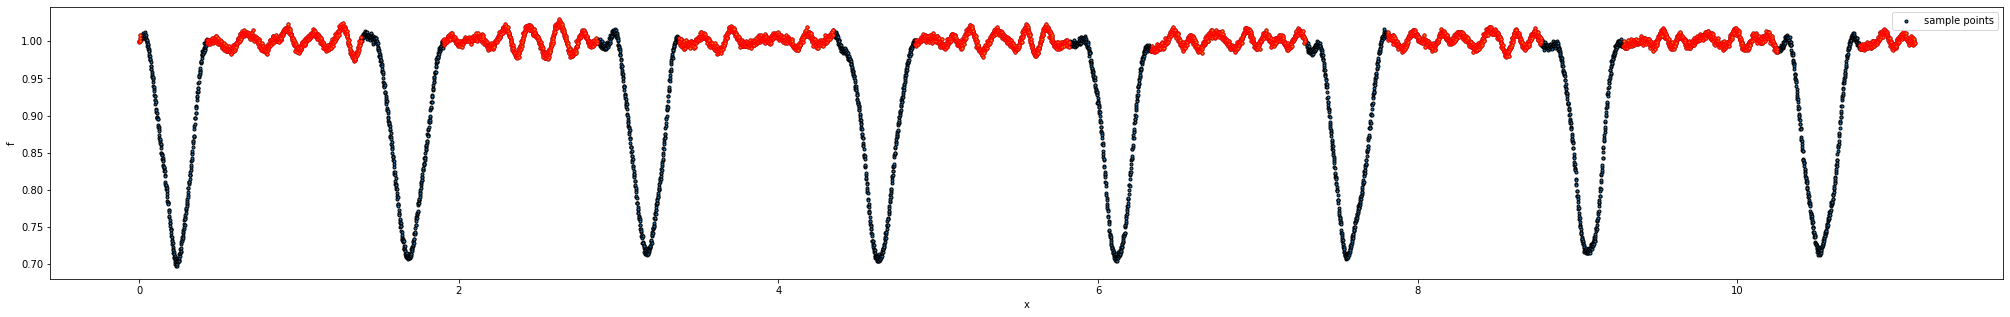

In [13]:
# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

In [14]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

array([0.        , 4.62657832, 4.60857607, 3.97849731, 3.60045006,
       3.61845231, 3.99649956, 4.64458057, 3.96049506, 4.48256032])

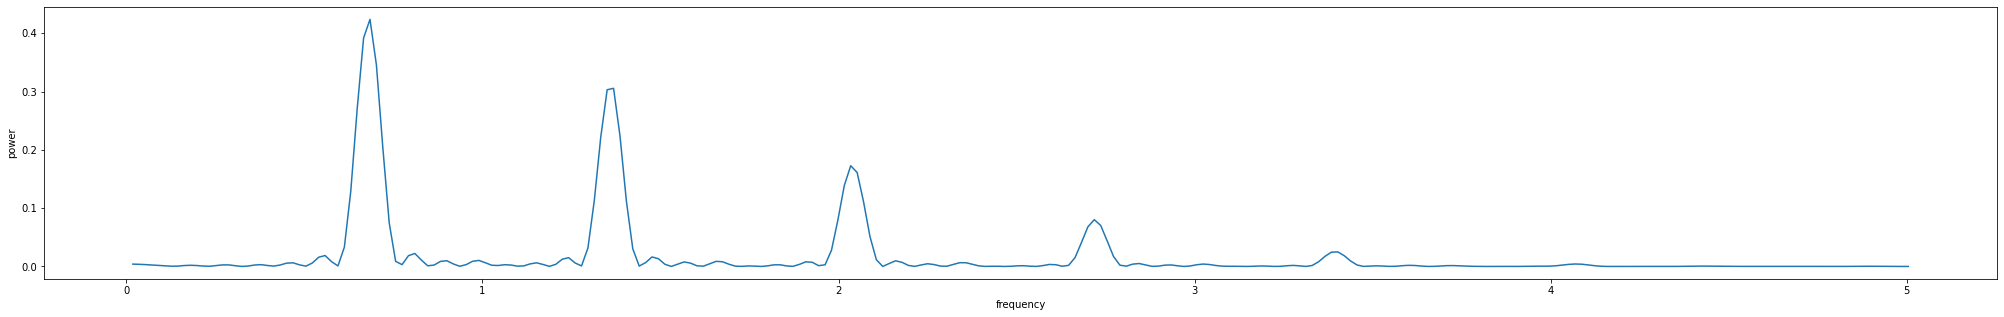

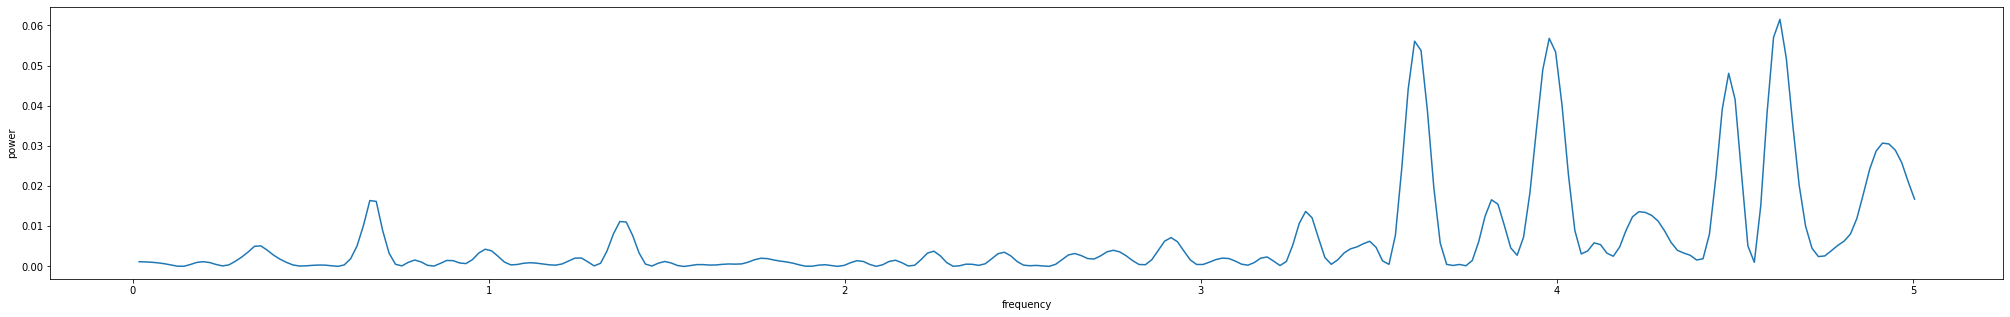

In [16]:
# Plot the periodogram before and after taking out the E.B.
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)
frequencies[np.argsort(power)[::-1][:10]]

In [17]:
main_period = 1/frequencies[np.argsort(power)[::-1][1]]

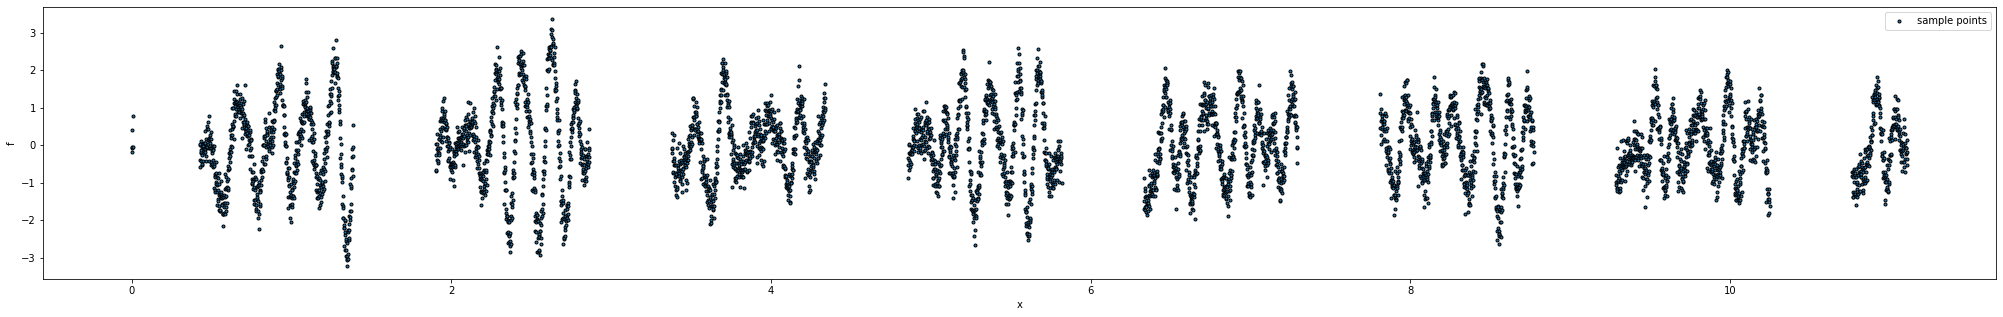

In [18]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal 
# has a major impact on the mean?
# In other words, if we normalize first, then remove the E.B., the remaining signal will be 
# somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
_, _, Y_part = experiment_util.normalize_mean(Y_part)
plotter.plot_data(X_part_window, Y_part_window)

In [19]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [20]:
# Initialize the S+LEAF model

# Two stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
calib_id = (X_without_gaps//1).astype(int) # One calibration per day
caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(X_without_gaps,
   err = term.Error(1),
   sho = term.SHOKernel(sig=-0.04314, P0=main_period, Q=8019.36505))

In [22]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part_window, cov_matrix, params_to_fit))

In [23]:
xbest

array([-3.73784042e+01,  1.53904408e-01,  8.01936505e+03])

In [24]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
Y_part_pred, var_pred = cov_matrix.conditional(Y_part_window, X_part, calc_cov='diag')

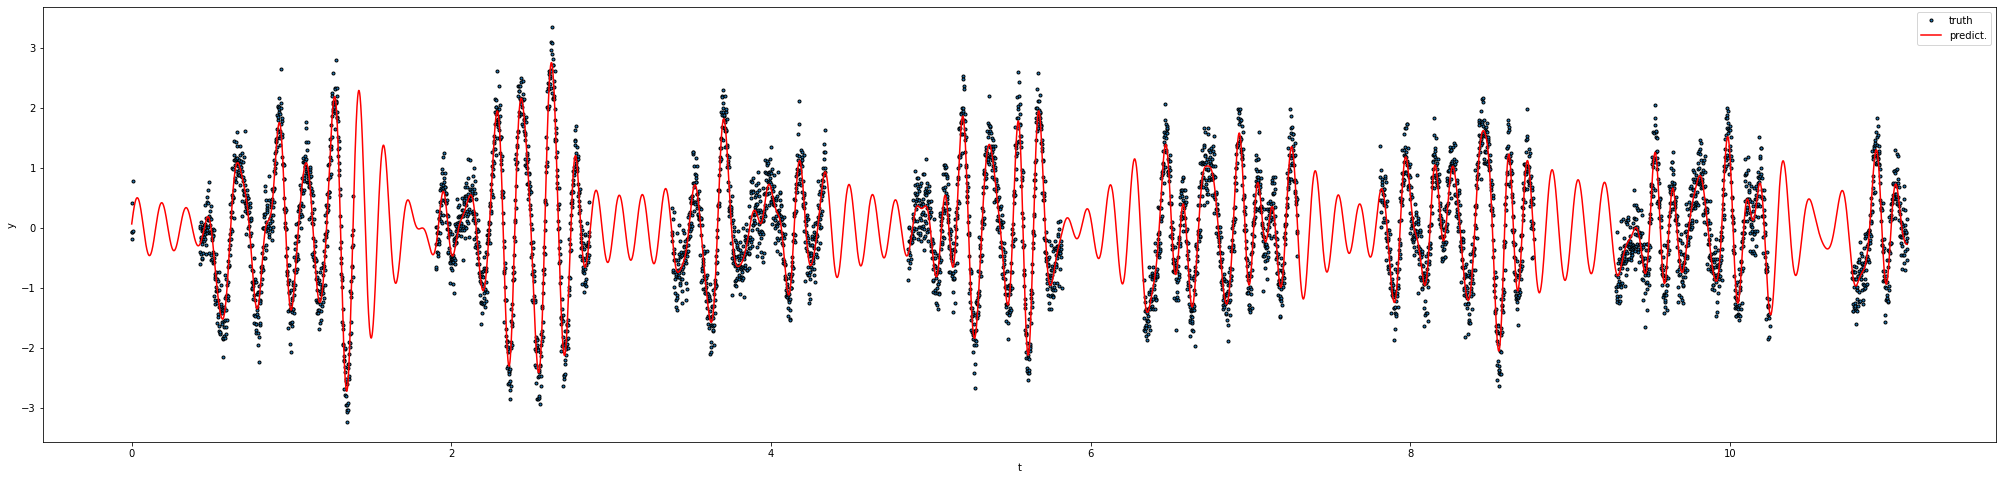

In [25]:
plotter.plot_series(X_part_window, Y_part_window, X_part, Y_part_pred)

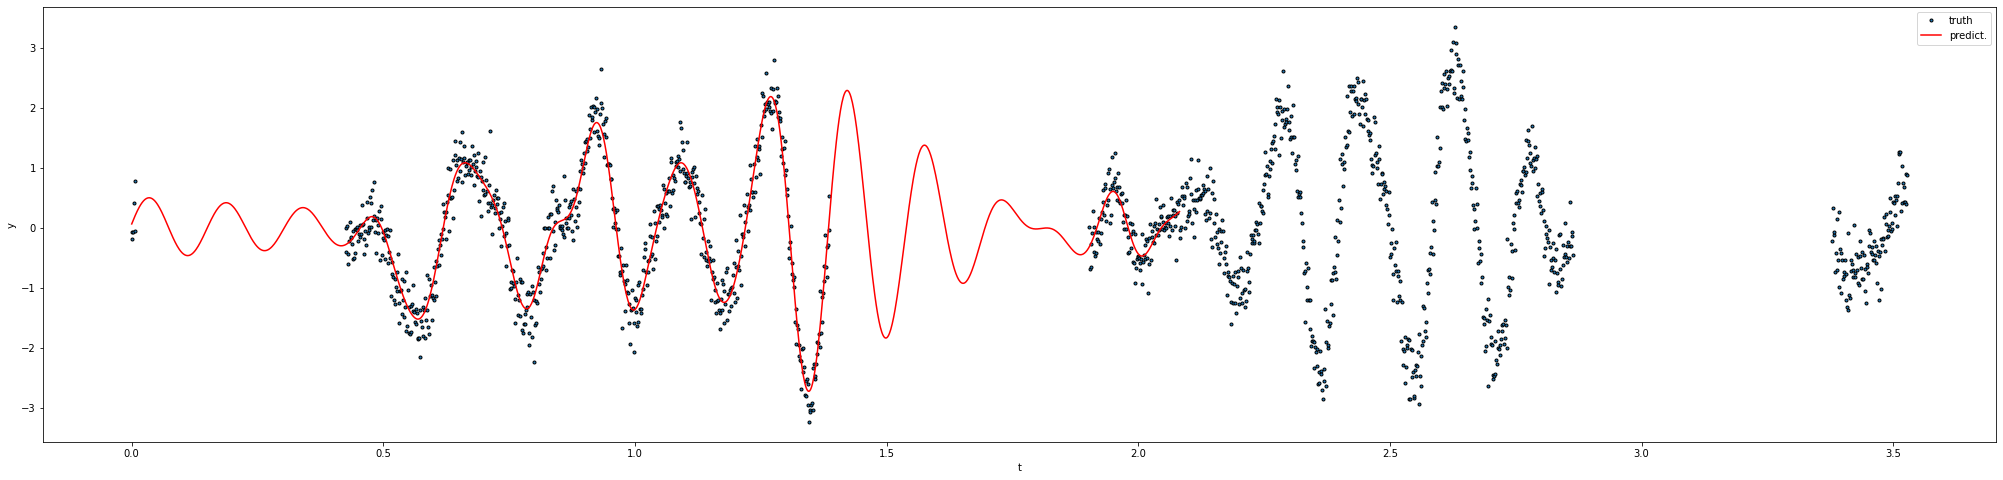

In [28]:
plotter.plot_series(X_part_window[:1500], Y_part_window[:1500], X_part[:1500], Y_part_pred[:1500])